<a href="https://colab.research.google.com/github/duydaomanhfake/ML_K3N2_Nhom8/blob/Bang/BTL_nh%C3%B3m_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

#Nối dataset từ drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

# Đọc dữ liệu
df = pd.read_csv('loan_data.csv')

# Làm sạch dữ liệu
df = df[df['person_age'] <= 120]  # Loại bỏ tuổi bất thường
df = df[df['person_emp_exp'] <= (df['person_age'] - 16)]  # Loại bỏ kinh nghiệm làm việc không hợp lý
df = df.dropna()  # Loại bỏ giá trị thiếu

# Phân chia đặc trưng và mục tiêu
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Các cột danh mục và số
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership',
                    'loan_intent', 'previous_loan_defaults_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
                 'credit_score']

# Tạo preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Áp dụng preprocessor trước SMOTE
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Xử lý mất cân bằng lớp bằng SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Định nghĩa các mô hình
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'k-NN': KNeighborsClassifier()
}

# Huấn luyện và đánh giá mô hình
results = {}
for name, model in models.items():
    # Huấn luyện mô hình trực tiếp trên dữ liệu đã tiền xử lý
    model.fit(X_train_resampled, y_train_resampled)

    # Dự đoán
    y_pred = model.predict(X_test_preprocessed)

    # Đánh giá
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    }

    print(f"\nResults for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")

# Tối ưu hóa Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'),
                              param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_search_lr.fit(X_train_resampled, y_train_resampled)

# Kết quả Logistic Regression tốt nhất
print("\nBest Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best F1-Score:", grid_search_lr.best_score_)

# Tối ưu hóa Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Kết quả Decision Tree tốt nhất
print("\nBest Decision Tree Parameters:", grid_search_dt.best_params_)
print("Best F1-Score:", grid_search_dt.best_score_)

# Tối ưu hóa k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(),
                               param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# Kết quả k-NN tốt nhất
print("\nBest k-NN Parameters:", grid_search_knn.best_params_)
print("Best F1-Score:", grid_search_knn.best_score_)

# Phân tích đặc trưng quan trọng (Decision Tree)
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = grid_search_dt.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print("\nFeature Importance (Decision Tree):")
print(feature_importance.sort_values(by='Importance', ascending=False).head(10))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      6999
           1       0.62      0.91      0.74      2000

    accuracy                           0.86      8999
   macro avg       0.79      0.88      0.82      8999
weighted avg       0.89      0.86      0.86      8999

Accuracy: 0.8554

Results for Naive Bayes:
              precision    recall  f1-score   support

           0       0.99      0.68      0.81      6999
           1       0.47      0.97      0.63      2000

    accuracy                           0.75      8999
   macro avg       0.73      0.83      0.72      8999
weighted avg       0.87      0.75      0.77      8999

Accuracy: 0.7481

Results for Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.92      0

In [13]:
# Trực quan hóa kết quả
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Biểu đồ cột so sánh hiệu suất
plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    values = [results[model][metric] for model in models.keys()]
    sns.barplot(x=list(models.keys()), y=values, palette='viridis')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.close()

# 2. Biểu đồ cột tầm quan trọng đặc trưng
plt.figure(figsize=(10, 6))
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')
plt.title('Top 10 Feature Importance (Decision Tree)')
plt.xlabel('Importance')
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')
plt.savefig('feature_importance.png')
plt.close()

# 3. Biểu đồ nhiệt ma trận nhầm lẫn
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models.items(), 1):
    # Dự đoán để tạo ma trận nhầm lẫn
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Approved (0)', 'Approved (1)'],
                yticklabels=['Not Approved (0)', 'Approved (1)'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.close()
plt.show()

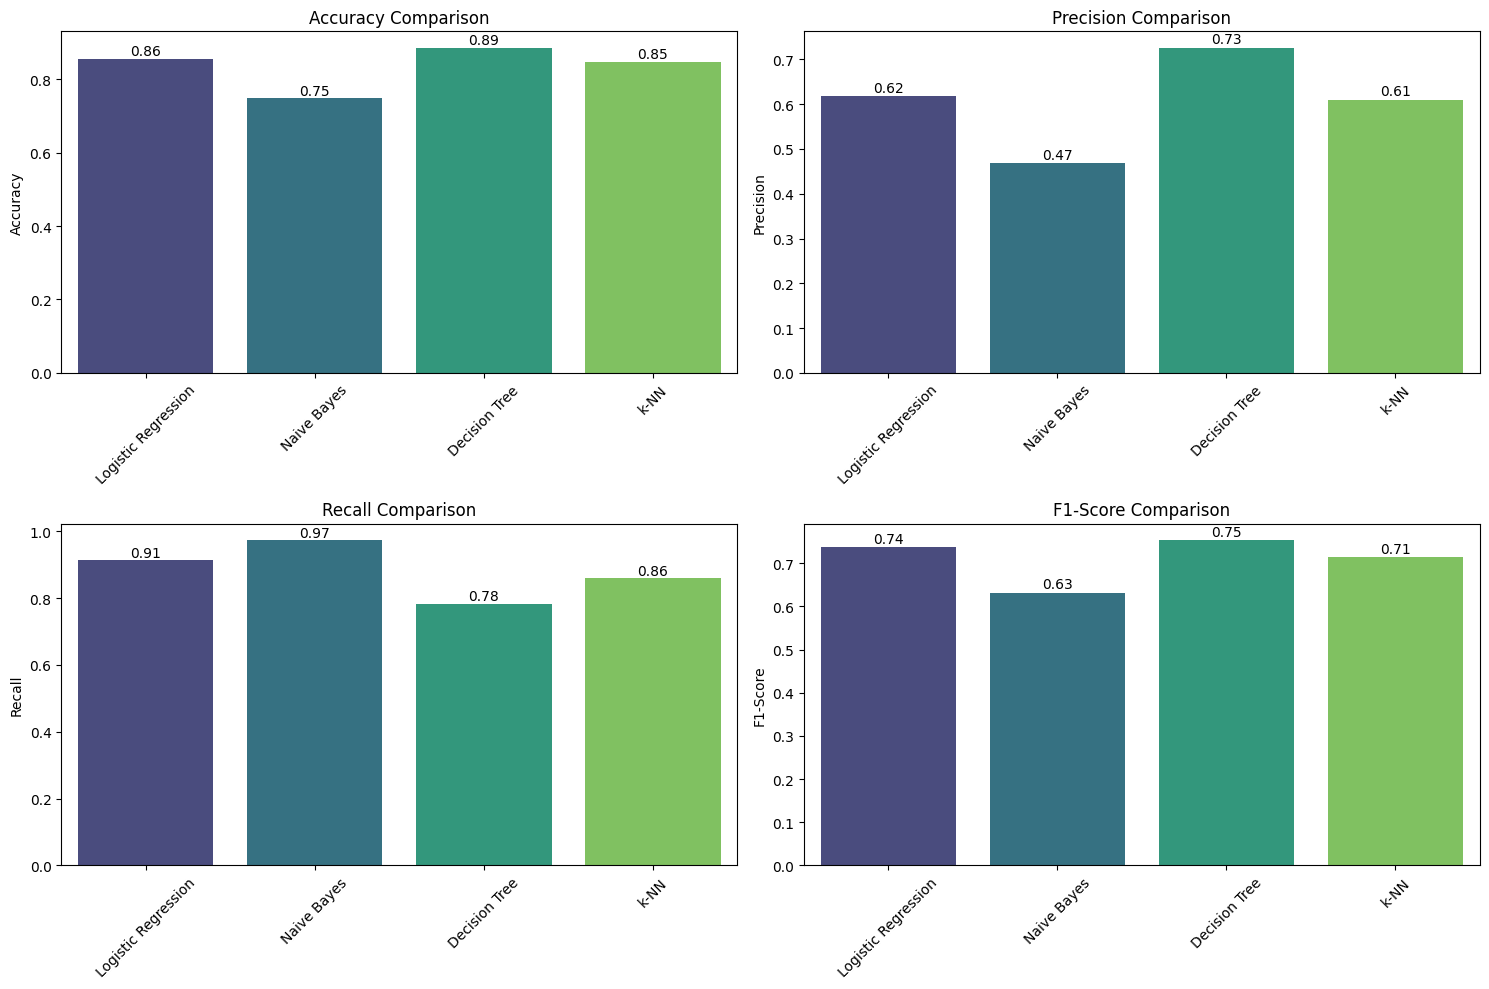

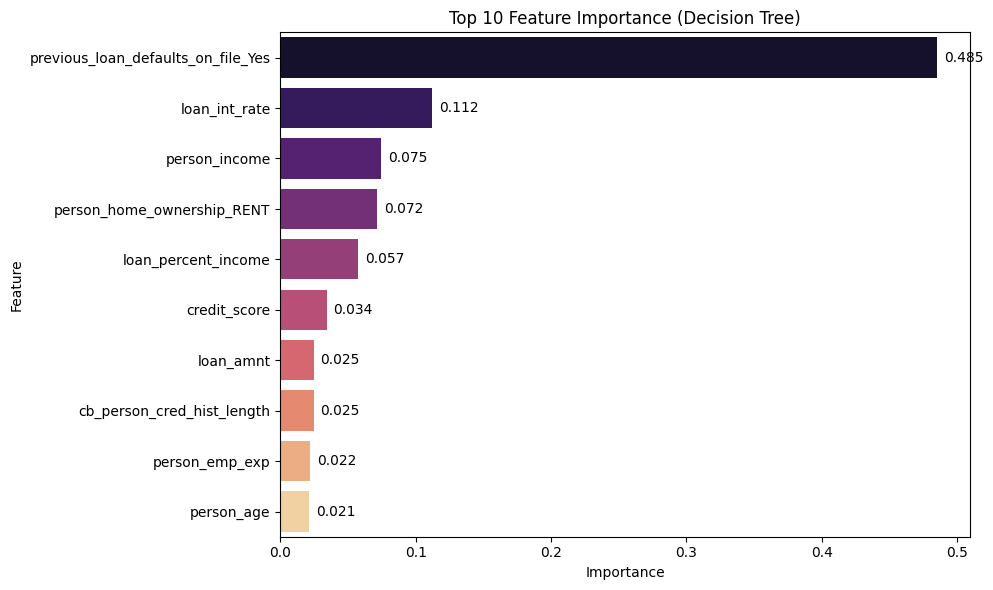

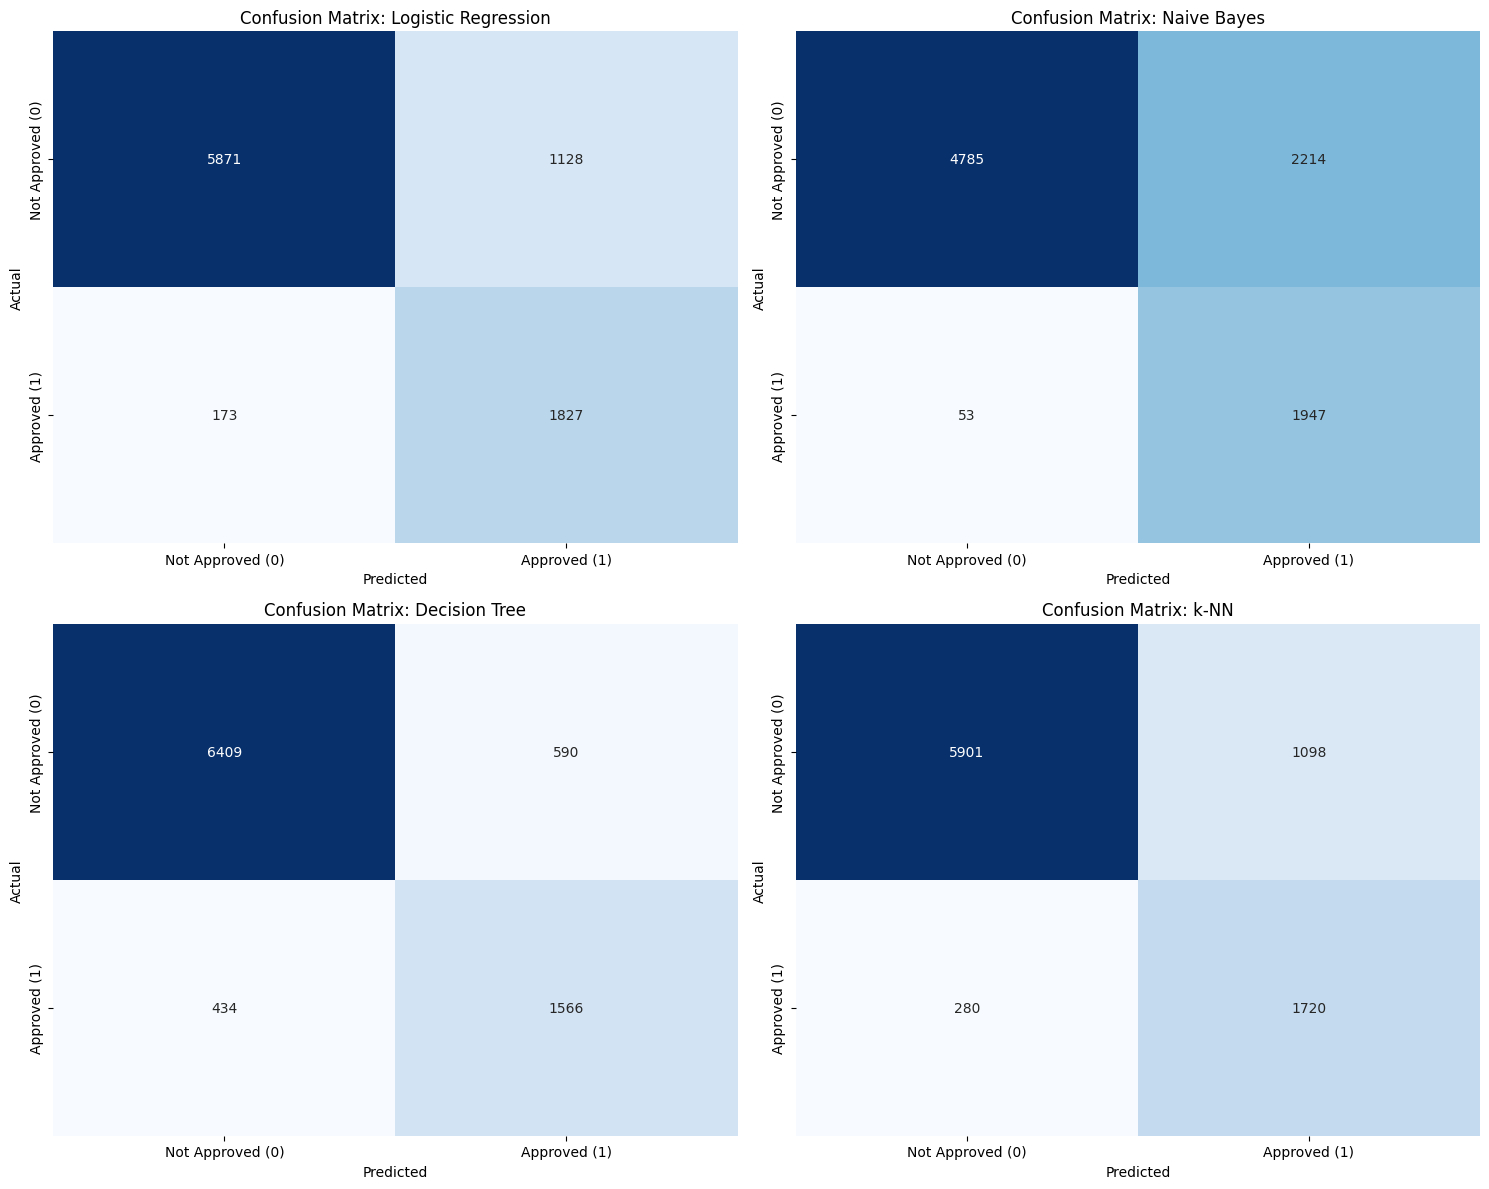

In [14]:
# Trực quan hóa kết quả
import matplotlib.pyplot as plt
import seaborn as sns

# Kích hoạt hiển thị trực tiếp trong Colab
%matplotlib inline

# 1. Biểu đồ cột so sánh hiệu suất
plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    values = [results[model][metric] for model in models.keys()]
    sns.barplot(x=list(models.keys()), y=values, palette='viridis')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# 2. Biểu đồ cột tầm quan trọng đặc trưng
plt.figure(figsize=(10, 6))
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')
plt.title('Top 10 Feature Importance (Decision Tree)')
plt.xlabel('Importance')
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()

# 3. Biểu đồ nhiệt ma trận nhầm lẫn
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models.items(), 1):
    # Dự đoán để tạo ma trận nhầm lẫn
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Approved (0)', 'Approved (1)'],
                yticklabels=['Not Approved (0)', 'Approved (1)'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()